# Marketing and Customer Analysis Project

This project examines the relationship between marketing spend, revenue, and customer behavior using transactional and marketing data covering a 12-month period from a publicly available dataset.  
Dataset source: [Marketing Insights for E-Commerce Company](https://www.kaggle.com/datasets/rishikumarrajvansh/marketing-insights-for-e-commerce-company) (Kaggle).

It is divided into two parts:

**Part I – How Does Marketing Spend Affects Revenue?**  
Evaluates whether total, online, and offline marketing spend (current and lagged) predict weekly revenue or customer acquisition after accounting for seasonality.

**Part II – Cohort and Segmentation Analysis**  
Analyzes customer retention and purchasing behavior by location through cohort analysis and segmentation. Includes retention matrices, average retention curves, location-level revenue comparisons, and identification of top-revenue products in each region.

The goal is to provide a clear, data-driven view of marketing effectiveness and customer dynamics to support informed decision-making.



## Data preparation:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

print("Libraries Loaded")

Libraries Loaded


In [2]:
sales = pd.read_csv("Marketing E-Commerce/Online_Sales.csv")
marketing_spend = pd.read_csv("Marketing E-Commerce/Marketing_Spend.csv")
customers = pd.read_excel("Marketing E-Commerce/CustomersData.xlsx")

pd.set_option('display.max_columns', None) ## making sure all columns are visible


### Organising the data:

In [3]:
sales.columns = sales.columns.str.lower()
sales.shape ## (52924 , 10)
sales.head()

,customerid,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [4]:
customers.columns = customers.columns.str.lower()
customers.shape ## (1468 , 4)
customers.head()

,customerid,gender,location,tenure_months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [5]:
marketing_spend.columns = marketing_spend.columns.str.lower()
marketing_spend.shape ## (365 , 3)
marketing_spend.head()

,date,offline_spend,online_spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


### Checking for NaNs:

In [6]:
sales.isna().sum()

customerid             0
transaction_id         0
transaction_date       0
product_sku            0
product_description    0
product_category       0
quantity               0
avg_price              0
delivery_charges       0
coupon_status          0
dtype: int64

In [7]:
customers.isna().sum()

customerid       0
gender           0
location         0
tenure_months    0
dtype: int64

In [8]:
marketing_spend.isna().sum()

date             0
offline_spend    0
online_spend     0
dtype: int64

# Part I: How Does Marketing Spend Affects Revenue?

In [9]:
sales['transaction_date'] = pd.to_datetime(sales['transaction_date'])
marketing_spend['date'] = pd.to_datetime(marketing_spend['date'])

In [10]:
print(marketing_spend['date'].dt.to_period('W').nunique() , "unique weeks in marketing_spend")
print(sales['transaction_date'].dt.to_period('W').nunique() , "unique weeks in sales")

53 unique weeks in marketing_spend
53 unique weeks in sales


### Aggregating by week:

In [11]:
sales['week'] = sales['transaction_date'].dt.to_period('W')
marketing_spend['week'] = marketing_spend['date'].dt.to_period('W')

sales['amount'] = sales['quantity']*sales['avg_price']

sales_weekly = sales.groupby('week' , as_index = False).agg(
    weekly_revenue = ('amount' , 'sum'))
marketing_spend_weekly = marketing_spend.groupby('week' , as_index = False).agg(
    weekly_online_spend = ('online_spend' , 'sum') ,
    weekly_offline_spend = ('offline_spend' , 'sum'))

df_merged = pd.merge(sales_weekly , marketing_spend_weekly , on = 'week' , how = 'outer') ## using 'outer' to make sure all rows from both tables are kept

df_merged['weekly_marketing_spend'] = df_merged['weekly_online_spend'] + df_merged['weekly_offline_spend']

df_merged = df_merged.sort_values('week')
df_merged.shape ## (53 , 5)
df_merged.head()


,week,weekly_revenue,weekly_online_spend,weekly_offline_spend,weekly_marketing_spend
0,2018-12-31/2019-01-06,92980.50,18261.94,27000,45261.94
1,2019-01-07/2019-01-13,83877.67,15577.37,34500,50077.37
2,2019-01-14/2019-01-20,89160.36,13940.16,23000,36940.16
3,2019-01-21/2019-01-27,87005.26,6357.66,9000,15357.66
4,2019-01-28/2019-02-03,87101.98,7746.97,5200,12946.97


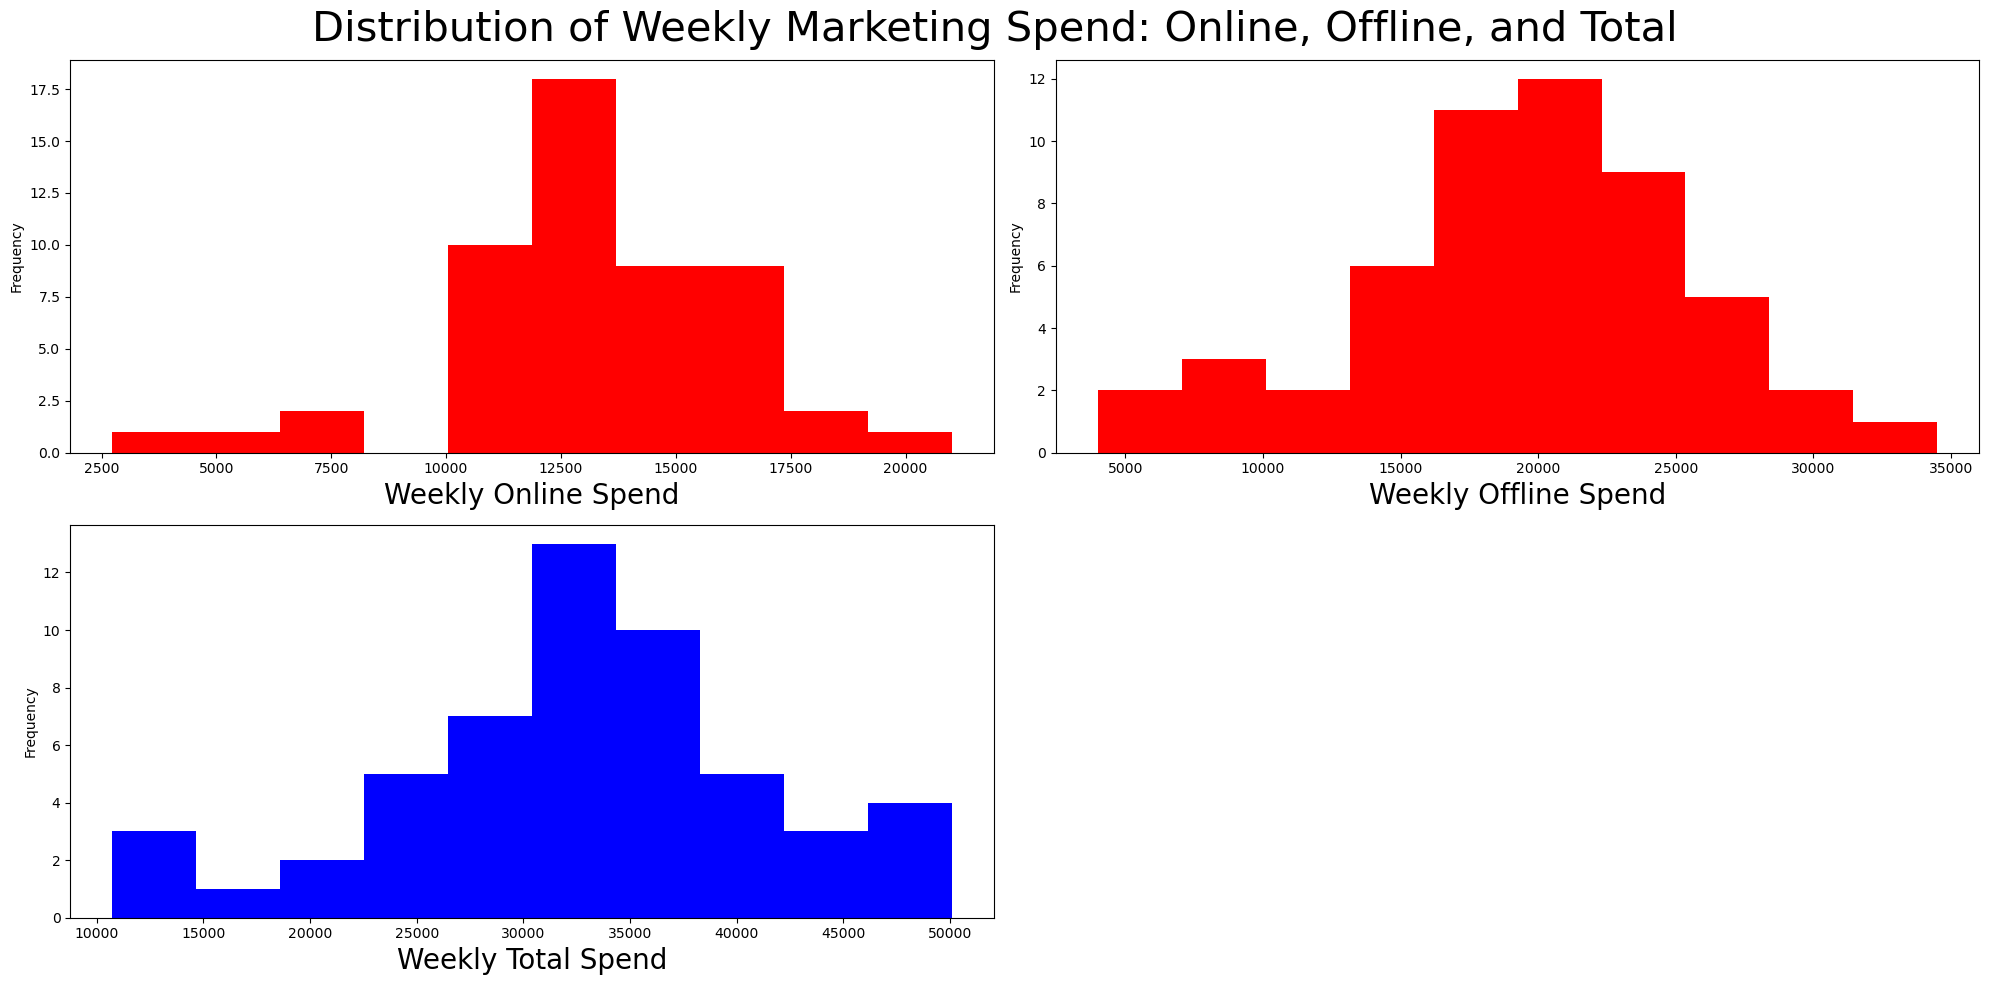

In [12]:
fig , ax = plt.subplots(2,2 , figsize = (20,10))

df_merged['weekly_online_spend'].plot(kind = 'hist' , ax = ax[0,0] , color = 'red')
df_merged['weekly_offline_spend'].plot(kind = 'hist' , ax = ax[0,1] , color = 'red')
df_merged['weekly_marketing_spend'].plot(kind = 'hist' , ax = ax[1,0] , color = 'blue')

fig.delaxes(ax[1,1])

ax[0,0].set_xlabel("Weekly Online Spend" , fontsize = 20)
ax[0,1].set_xlabel("Weekly Offline Spend" , fontsize = 20)
ax[1,0].set_xlabel("Weekly Total Spend" , fontsize = 20)
fig.suptitle("Distribution of Weekly Marketing Spend: Online, Offline, and Total" , fontsize = 30)
                   

plt.tight_layout()
plt.show()



<Axes: title={'center': 'Distribution Of Weekly Revenue'}, xlabel='Weekly Revenue', ylabel='Frequency'>

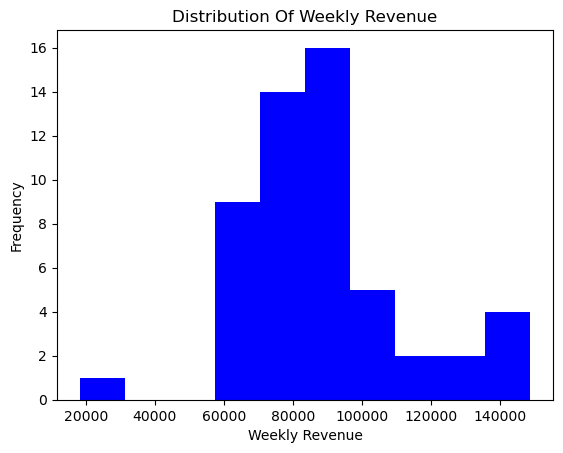

In [13]:
df_merged['weekly_revenue'].plot(
    kind = 'hist' , 
    title = "Distribution Of Weekly Revenue" , 
    xlabel = "Weekly Revenue" , 
    color = 'blue')

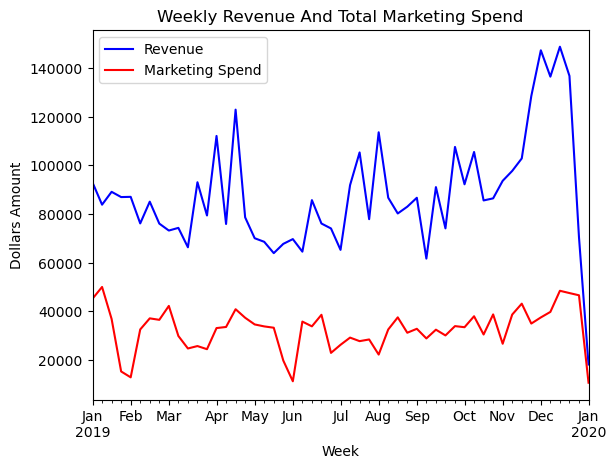

In [14]:
fig, ax = plt.subplots()

df_merged.plot(x = 'week' , y = 'weekly_revenue' , kind = 'line' , ax = ax , label = 'Revenue' , color = 'blue')
df_merged.plot(x = 'week' , y = 'weekly_marketing_spend' , kind = 'line' , ax = ax , label = 'Marketing Spend' , color = 'red')

ax.set_title("Weekly Revenue And Total Marketing Spend")
ax.set_xlabel("Week")
ax.set_ylabel("Dollars Amount")
ax.legend()

plt.show()


<Axes: title={'center': 'Weekly Revenue VS Weekly Marketing Spend'}, xlabel='Weekly Marketing Spend', ylabel='Weekly Revenue'>

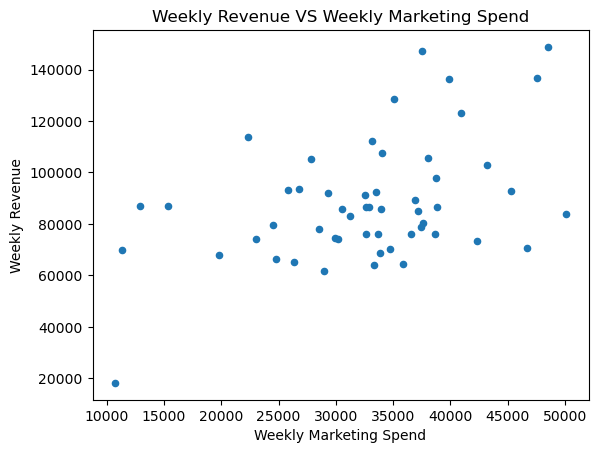

In [15]:
df_merged.plot(
    x = 'weekly_marketing_spend' , 
    y = 'weekly_revenue' , 
    kind = 'scatter' , 
    title = "Weekly Revenue VS Weekly Marketing Spend" ,
    xlabel = "Weekly Marketing Spend" ,
    ylabel = "Weekly Revenue")


#### There seems to be an outlier around (10000 , 20000)

#### The minimum revenue value (~20,000) appears to be an outlier.  
#### The next smallest value is approximately 60,000, and all other values range from about 60,000 to ~150,000. 
#### This large gap between the minimum and the rest of the distribution indicates that the lowest value is unusually low relative to the dataset.
#### Given this discontinuity, the outlier is removed for the rest of the analyses.



In [16]:
min_weekly_revenue = df_merged['weekly_revenue'].min()
min_weekly_revenue

18216.79

In [17]:
## removing the outlier
df_merged = df_merged[df_merged['weekly_revenue'] != min_weekly_revenue].copy()

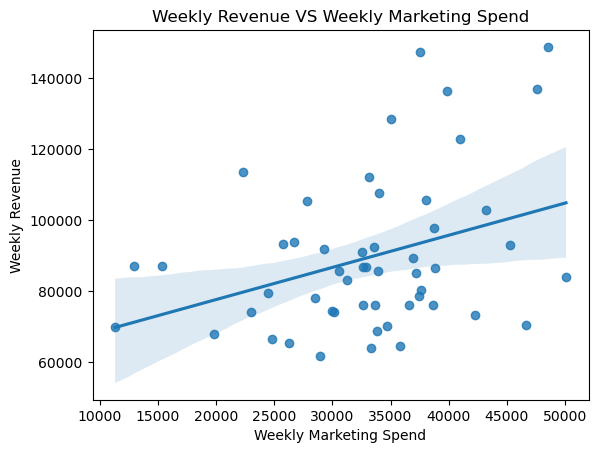

In [18]:
sns.regplot(data = df_merged,  x= 'weekly_marketing_spend',  y = 'weekly_revenue') 
plt.title("Weekly Revenue VS Weekly Marketing Spend")
plt.xlabel("Weekly Marketing Spend")
plt.ylabel("Weekly Revenue")
plt.show()


### Transforming to log variables (note that all values are greater then zero, so there's no need for log(1+x)):

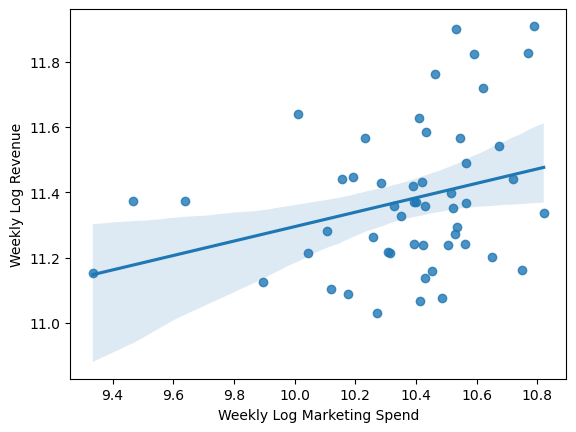

In [19]:
df_merged['weekly_log_spend'] = np.log(df_merged['weekly_marketing_spend'])
df_merged['weekly_log_revenue'] = np.log(df_merged['weekly_revenue'])

sns.regplot(data = df_merged, x='weekly_log_spend', y='weekly_log_revenue') 
plt.xlabel("Weekly Log Marketing Spend")
plt.ylabel("Weekly Log Revenue")
plt.show()

### Running a naive regression:

In [20]:
base_model = smf.ols("weekly_revenue ~ weekly_marketing_spend" , data = df_merged).fit(cov_type = 'HC1')
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weekly_revenue   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.967
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0182
Time:                        20:31:43   Log-Likelihood:                -588.66
No. Observations:                  52   AIC:                             1181.
Df Residuals:                      50   BIC:                             1185.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.944e+04   1.13e+04      5.244      0.000    3.72e+04    8.17e+04
weekly_marketing_spend     0.9065      0.371      2.443      0.015       0.179       1.634
==============================================================================
Omnibus:                        6.272   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.917
Skew:                           0.826   Prob(JB):                       0.0519
Kurtosis:                       3.034   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### An increase of 1 dollar in total weekly marketing spend is assosicated with an increase of approximately 0.906 dollars in weekly revenue.
### The result is statistically significant at the 5% level.
### This means that, on average, there is a weekly loss of approximately 0.094 dollars per dollar spent on marketing.

### Now, running a naive log-log regression:

In [21]:
base_model_log = smf.ols("weekly_log_revenue ~ weekly_log_spend" , data = df_merged).fit(cov_type = 'HC1')
base_model_log.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     5.596
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0219
Time:                        20:31:43   Log-Likelihood:                 7.6091
No. Observations:                  52   AIC:                            -11.22
Df Residuals:                      50   BIC:                            -7.316
Df Model:                           1                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.0818      0.961      9.449      0.000       7.198      10.966
weekly_log_spend     0.2213      0.094      2.366      0.018       0.038       0.405
==============================================================================
Omnibus:                        3.015   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.855
Skew:                           0.516   Prob(JB):                        0.240
Kurtosis:                       2.498   Cond. No.                         365.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### In a log-log model, the elasticity is 0.221, meaning a 10% increase in total weekly marketing spend is associated with approximately a 2.21% increase in weekly revenue.
### The result is significant at the 5% level.

### Transforming online and offline spends to log variables (again, no need for log(1+x)):

In [22]:
df_merged['weekly_log_online'] = np.log(df_merged['weekly_online_spend'])
df_merged['weekly_log_offline'] = np.log(df_merged['weekly_offline_spend'])

model_log_offline = smf.ols("weekly_log_revenue ~ weekly_log_offline" , data = df_merged).fit(cov_type = 'HC1')
model_log_offline.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.703
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0349
Time:                        20:31:43   Log-Likelihood:                 6.7321
No. Observations:                  52   AIC:                            -9.464
Df Residuals:                      50   BIC:                            -5.562
Df Model:                           1                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.0598      0.599     16.795      0.000       8.886      11.234
weekly_log_offline     0.1339      0.062      2.169      0.030       0.013       0.255
==============================================================================
Omnibus:                        3.702   Durbin-Watson:                   1.202
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.552
Skew:                           0.620   Prob(JB):                        0.169
Kurtosis:                       2.677   Cond. No.                         246.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### A 10% increase in weekly offline marketing spend is associated with an increase of approximately 1.339% in weekly revenue.
### The result is stasitically significant at the 5% level.

In [23]:
model_log_online = smf.ols("weekly_log_revenue ~ weekly_log_online" , data = df_merged).fit(cov_type = 'HC1')
model_log_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.441
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0143
Time:                        20:31:43   Log-Likelihood:                 9.5963
No. Observations:                  52   AIC:                            -15.19
Df Residuals:                      50   BIC:                            -11.29
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.5686      1.493      5.070      0.000       4.642      10.495
weekly_log_online     0.4019      0.158      2.538      0.011       0.092       0.712
==============================================================================
Omnibus:                        2.165   Durbin-Watson:                   1.339
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                1.693
Skew:                           0.273   Prob(JB):                        0.429
Kurtosis:                       2.304   Cond. No.                         420.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### A 10% increase in weekly online marketing spend is associated with an increase of approximately 4.019% in weekly revenue.
### The result is statistically significant at the 5% level.

In [24]:
df_merged[['weekly_log_online' , 'weekly_log_offline']].corr()

,weekly_log_online,weekly_log_offline
weekly_log_online,1.000000,0.801349
weekly_log_offline,0.801349,1.000000


### Note that weekly online and offline marketing spend are highly correlated (>0.7), i.e. collinear, so the coefficients are unstable and isolating their individual effects may not be possible.


In [25]:
model_log_online_offlne = smf.ols("weekly_log_revenue ~ weekly_log_online + weekly_log_offline" , data = df_merged).fit(cov_type = 'HC1')
model_log_online_offlne.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     3.143
Date:                Sat, 22 Nov 2025   Prob (F-statistic):             0.0520
Time:                        20:31:44   Log-Likelihood:                 10.080
No. Observations:                  52   AIC:                            -14.16
Df Residuals:                      49   BIC:                            -8.307
Df Model:                           2                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.0932      1.750      4.054      0.000       3.664      10.523
weekly_log_online      0.5711      0.280      2.040      0.041       0.023       1.120
weekly_log_offline    -0.1147      0.124     -0.928      0.353      -0.357       0.128
==============================================================================
Omnibus:                        1.127   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.569   Jarque-Bera (JB):                1.053
Skew:                           0.177   Prob(JB):                        0.591
Kurtosis:                       2.399   Cond. No.                         652.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### A 10% increase in weekly online marketing spend is associated with an increase of approximately 5.71% in weekly revenue, all else equal.
### The result is significant at the 5% level.
### Weekly offline spend is not statistically significant at the 5% level.

### Now, adding seasonality controls (quarters):

In [26]:
df_merged['week'] = df_merged['week'].dt.to_timestamp()
df_merged['quarter'] = df_merged['week'].dt.to_period('Q')

df_merged.columns

Index(['week', 'weekly_revenue', 'weekly_online_spend', 'weekly_offline_spend',
       'weekly_marketing_spend', 'weekly_log_spend', 'weekly_log_revenue',
       'weekly_log_online', 'weekly_log_offline', 'quarter'],
      dtype='object')

In [27]:
df_merged['quarter'].unique()

<PeriodArray>
['2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4']
Length: 5, dtype: period[Q-DEC]

In [28]:
df_merged['quarter'] = df_merged['quarter'].astype(str)

season_model_log = smf.ols(
    "weekly_log_revenue ~ weekly_log_spend + C(quarter , Treatment(reference='2019Q1'))" , 
    data = df_merged).fit(cov_type = 'HC1')
season_model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     7.755
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           2.34e-05
Time:                        20:31:44   Log-Likelihood:                 16.159
No. Observations:                  52   AIC:                            -20.32
Df Residuals:                      46   BIC:                            -8.610
Df Model:                           5                                         
Covariance Type:                  HC1                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              10.5330      0.802     13.129      0.000       8.961      12.105
C(quarter, Treatment(reference='2019Q1'))[T.2018Q4]     0.1097      0.042      2.612      0.009       0.027       0.192
C(quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -0.0398      0.062     -0.640      0.522      -0.162       0.082
C(quarter, Treatment(reference='2019Q1'))[T.2019Q3]     0.0585      0.059      0.998      0.318      -0.056       0.173
C(quarter, Treatment(reference='2019Q1'))[T.2019Q4]     0.2777      0.075      3.709      0.000       0.131       0.424
weekly_log_spend                                        0.0744      0.077      0.961      0.336      -0.077       0.226
==============================================================================
Omnibus:                        0.791   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.462
Skew:                           0.230   Prob(JB):                        0.794
Kurtosis:                       3.042   Cond. No.                         398.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### After controlling for seasonality (quarters), weekly total spend is not statistically significant.

In [29]:
season_log_online_offlne = smf.ols(
    "weekly_log_revenue ~ weekly_log_online + weekly_log_offline + C(quarter , Treatment(reference = '2019Q1'))" , 
    data = df_merged).fit(cov_type = 'HC1')
season_log_online_offlne.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     6.016
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           0.000111
Time:                        20:31:44   Log-Likelihood:                 17.280
No. Observations:                  52   AIC:                            -20.56
Df Residuals:                      45   BIC:                            -6.902
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               9.0017      1.601      5.622      0.000       5.863      12.140
C(quarter, Treatment(reference='2019Q1'))[T.2018Q4]     0.0336      0.072      0.466      0.641      -0.108       0.175
C(quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -0.0657      0.065     -1.004      0.315      -0.194       0.063
C(quarter, Treatment(reference='2019Q1'))[T.2019Q3]     0.0470      0.057      0.825      0.410      -0.065       0.159
C(quarter, Treatment(reference='2019Q1'))[T.2019Q4]     0.2311      0.070      3.293      0.001       0.094       0.369
weekly_log_online                                       0.3487      0.266      1.310      0.190      -0.173       0.870
weekly_log_offline                                     -0.0996      0.120     -0.831      0.406      -0.335       0.135
==============================================================================
Omnibus:                        0.936   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.626   Jarque-Bera (JB):                0.317
Skew:                           0.085   Prob(JB):                        0.853
Kurtosis:                       3.343   Cond. No.                         775.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### After controlling for seasonality (quarters), weekly online and offline spend are not statistically significant.

### Next, analyzing the lag effect of weekly marketing spend:




In [30]:
df_merged = df_merged.sort_values('week')
df_merged['prev_week_log_spend'] = df_merged['weekly_log_spend'].shift(1)

In [31]:
df_merged.head()

,week,weekly_revenue,weekly_online_spend,weekly_offline_spend,weekly_marketing_spend,weekly_log_spend,weekly_log_revenue,weekly_log_online,weekly_log_offline,quarter,prev_week_log_spend
0,2018-12-31,92980.50,18261.94,27000,45261.94,10.720222,11.440145,9.812574,10.203592,2018Q4,NaN
1,2019-01-07,83877.67,15577.37,34500,50077.37,10.821324,11.337115,9.653574,10.448715,2019Q1,10.720222
2,2019-01-14,89160.36,13940.16,23000,36940.16,10.517055,11.398192,9.542529,10.043249,2019Q1,10.821324
3,2019-01-21,87005.26,6357.66,9000,15357.66,9.639370,11.373724,8.757416,9.104980,2019Q1,10.517055
4,2019-01-28,87101.98,7746.97,5200,12946.97,9.468617,11.374835,8.955057,8.556414,2019Q1,9.639370


Text(0, 0.5, 'Weekly Log Revenue')

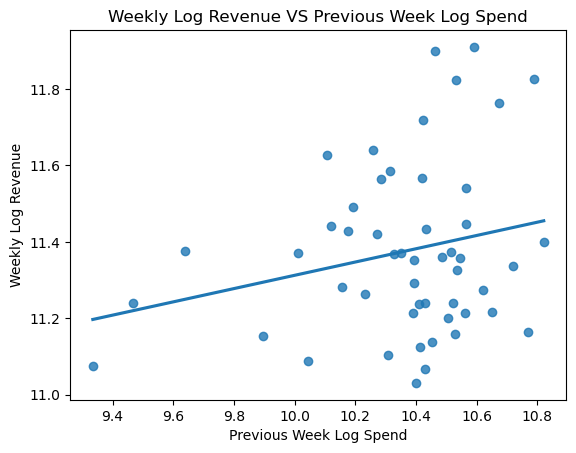

In [32]:
sns.regplot(data = df_merged, x='prev_week_log_spend', y='weekly_log_revenue', ci=None)
plt.title("Weekly Log Revenue VS Previous Week Log Spend")
plt.xlabel("Previous Week Log Spend")
plt.ylabel("Weekly Log Revenue")

In [33]:
model_lag = smf.ols("weekly_log_revenue ~ prev_week_log_spend + C(quarter , Treatment(reference = '2019Q1'))" , data = df_merged).fit(cov_type = 'HC1')
model_lag.summary()

C:\Users\asafk\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     4.359
Date:                Sat, 22 Nov 2025   Prob (F-statistic):            0.00451
Time:                        20:31:44   Log-Likelihood:                 15.158
No. Observations:                  51   AIC:                            -20.32
Df Residuals:                      46   BIC:                            -10.66
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              10.8160      0.699     15.482      0.000       9.447      12.185
C(quarter, Treatment(reference='2019Q1'))[T.2018Q4] -2.219e-16   2.98e-16     -0.746      0.456   -8.05e-16    3.61e-16
C(quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -0.0364      0.063     -0.577      0.564      -0.160       0.087
C(quarter, Treatment(reference='2019Q1'))[T.2019Q3]     0.0636      0.056      1.133      0.257      -0.046       0.174
C(quarter, Treatment(reference='2019Q1'))[T.2019Q4]     0.2896      0.075      3.875      0.000       0.143       0.436
prev_week_log_spend                                     0.0466      0.068      0.690      0.490      -0.086       0.179
==============================================================================
Omnibus:                        1.097   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.642
Skew:                           0.269   Prob(JB):                        0.725
Kurtosis:                       3.109   Cond. No.                     4.39e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 2.87e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Previous week marketing spend is not statistically significant when controlling for seasonality.

In [34]:
df_merged = df_merged.sort_values('week')
df_merged['two_weeks_lag_spend'] = df_merged['weekly_log_spend'].shift(2)
df_merged.head()

,week,weekly_revenue,weekly_online_spend,weekly_offline_spend,weekly_marketing_spend,weekly_log_spend,weekly_log_revenue,weekly_log_online,weekly_log_offline,quarter,prev_week_log_spend,two_weeks_lag_spend
0,2018-12-31,92980.50,18261.94,27000,45261.94,10.720222,11.440145,9.812574,10.203592,2018Q4,NaN,NaN
1,2019-01-07,83877.67,15577.37,34500,50077.37,10.821324,11.337115,9.653574,10.448715,2019Q1,10.720222,NaN
2,2019-01-14,89160.36,13940.16,23000,36940.16,10.517055,11.398192,9.542529,10.043249,2019Q1,10.821324,10.720222
3,2019-01-21,87005.26,6357.66,9000,15357.66,9.639370,11.373724,8.757416,9.104980,2019Q1,10.517055,10.821324
4,2019-01-28,87101.98,7746.97,5200,12946.97,9.468617,11.374835,8.955057,8.556414,2019Q1,9.639370,10.517055


In [35]:
model_two_lag = smf.ols("weekly_log_revenue ~ two_weeks_lag_spend + C(quarter , Treatment(reference = '2019Q1'))" , data = df_merged).fit(cov_type = 'HC1')
model_two_lag.summary()

C:\Users\asafk\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     5.264
Date:                Sat, 22 Nov 2025   Prob (F-statistic):            0.00145
Time:                        20:31:45   Log-Likelihood:                 14.513
No. Observations:                  50   AIC:                            -19.03
Df Residuals:                      45   BIC:                            -9.466
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              11.9665      0.654     18.292      0.000      10.684      13.249
C(quarter, Treatment(reference='2019Q1'))[T.2018Q4]  1.803e-14   9.94e-16     18.134      0.000    1.61e-14       2e-14
C(quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -0.0362      0.064     -0.564      0.573      -0.162       0.090
C(quarter, Treatment(reference='2019Q1'))[T.2019Q3]     0.0640      0.057      1.123      0.261      -0.048       0.176
C(quarter, Treatment(reference='2019Q1'))[T.2019Q4]     0.3148      0.077      4.101      0.000       0.164       0.465
two_weeks_lag_spend                                    -0.0652      0.064     -1.019      0.308      -0.191       0.060
==============================================================================
Omnibus:                        1.351   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.022
Skew:                           0.350   Prob(JB):                        0.600
Kurtosis:                       2.965   Cond. No.                     2.17e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 1.15e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Marketing spend two weeks prior is not statistically significant when controlling for seasonality.

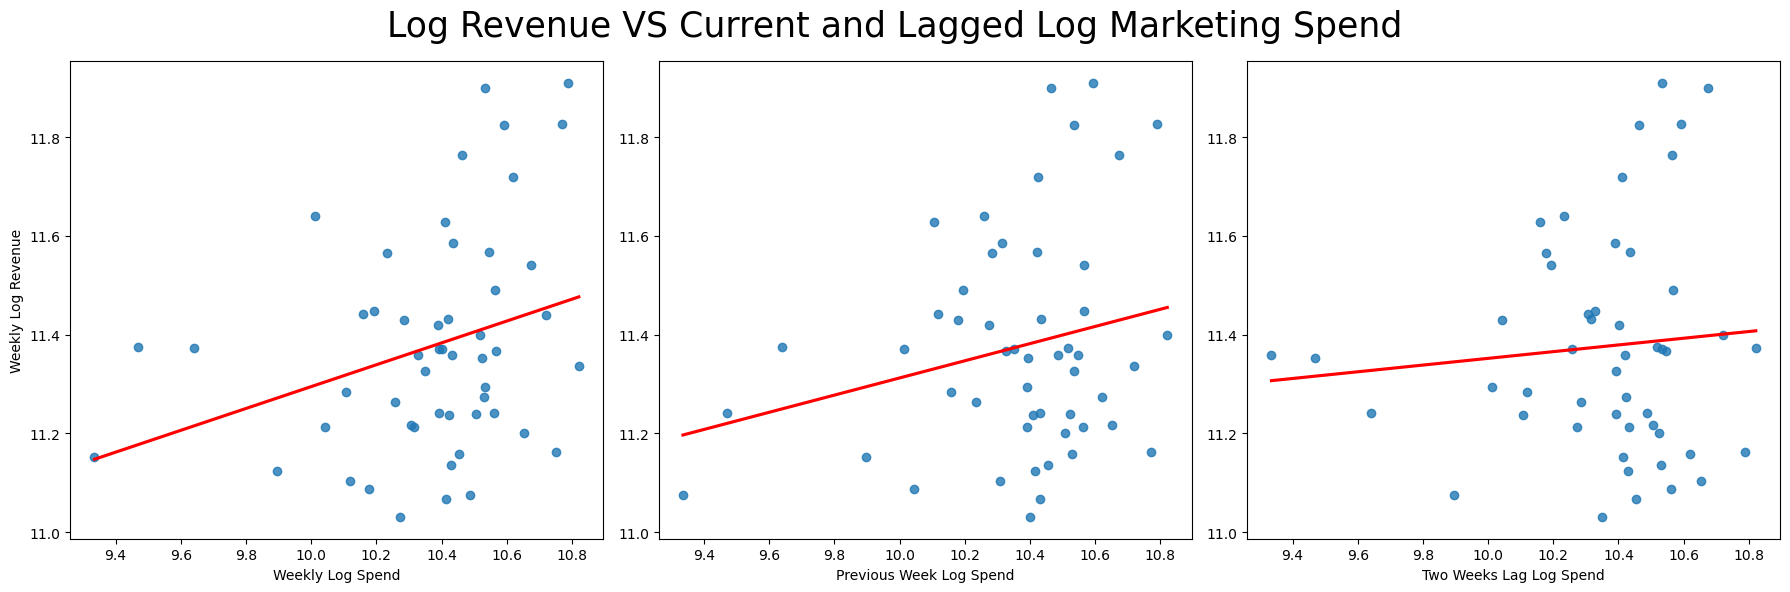

In [36]:
fig , ax = plt.subplots(1 , 3 , figsize=(18 , 6))

sns.regplot(data = df_merged, x='weekly_log_spend', y='weekly_log_revenue' , ax = ax[0], ci = None , line_kws={'color': 'red'} )
sns.regplot(data = df_merged, x='prev_week_log_spend', y='weekly_log_revenue' , ax = ax[1] , ci = None , line_kws={'color': 'red'})
sns.regplot(data = df_merged, x='two_weeks_lag_spend', y='weekly_log_revenue', ax = ax[2] , ci = None , line_kws={'color': 'red'})


ax[0].set_xlabel("Weekly Log Spend")
ax[0].set_ylabel("Weekly Log Revenue")
ax[1].set_xlabel("Previous Week Log Spend")
ax[1].set_ylabel("")
ax[2].set_xlabel("Two Weeks Lag Log Spend")
ax[2].set_ylabel("")
fig.suptitle("Log Revenue VS Current and Lagged Log Marketing Spend", fontsize=25)


plt.tight_layout()
plt.show()

### Note the diminishing correlation between weekly marketing spend and revenues from left (current) to right (lagged).

In [37]:
model_current_and_lags = smf.ols(
    "weekly_log_revenue ~ weekly_log_spend + prev_week_log_spend + two_weeks_lag_spend +C(quarter , Treatment(reference = '2019Q1'))" , 
    data = df_merged).fit(cov_type = 'HC1')
model_current_and_lags.summary()

C:\Users\asafk\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     weekly_log_revenue   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3.616
Date:                Sat, 22 Nov 2025   Prob (F-statistic):            0.00543
Time:                        20:31:46   Log-Likelihood:                 14.874
No. Observations:                  50   AIC:                            -15.75
Df Residuals:                      43   BIC:                            -2.363
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              11.0806      1.470      7.535      0.000       8.199      13.963
C(quarter, Treatment(reference='2019Q1'))[T.2018Q4] -1.615e-16   2.84e-16     -0.568      0.570   -7.19e-16    3.96e-16
C(quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -0.0424      0.063     -0.678      0.498      -0.165       0.080
C(quarter, Treatment(reference='2019Q1'))[T.2019Q3]     0.0589      0.061      0.963      0.336      -0.061       0.179
C(quarter, Treatment(reference='2019Q1'))[T.2019Q4]     0.2881      0.078      3.672      0.000       0.134       0.442
weekly_log_spend                                        0.0399      0.105      0.381      0.703      -0.165       0.245
prev_week_log_spend                                     0.0591      0.090      0.657      0.511      -0.117       0.235
two_weeks_lag_spend                                    -0.0777      0.076     -1.021      0.307      -0.227       0.071
==============================================================================
Omnibus:                        1.319   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                0.953
Skew:                           0.338   Prob(JB):                        0.621
Kurtosis:                       2.999   Cond. No.                     6.75e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 3.54e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Controlling for seasonality, current and lagged marketing spend are not statistically significant.

### Next, analysing marketing spend and new customers:

In [38]:
sales.rename(columns = {'customerid' : 'customer_id'} , inplace = True)

sales['first_order'] = sales.groupby('customer_id')['transaction_date'].transform('min')
sales['cohort_week'] = sales['first_order'].dt.to_period('W')

weeks_new_customers = sales.groupby('cohort_week' , as_index = False).agg(
    new_customers = ('customer_id' , 'nunique'))

weeks_new_customers['cohort_quarter'] = weeks_new_customers['cohort_week'].dt.to_timestamp().dt.to_period('Q').astype(str)

weeks_new_customers['new_customers'].sum() ## 1468 , which is the same as the total number of customers
weeks_new_customers.head()


,cohort_week,new_customers,cohort_quarter
0,2018-12-31/2019-01-06,44,2018Q4
1,2019-01-07/2019-01-13,41,2019Q1
2,2019-01-14/2019-01-20,45,2019Q1
3,2019-01-21/2019-01-27,40,2019Q1
4,2019-01-28/2019-02-03,58,2019Q1


In [39]:
print(df_merged['week'].dtype)
print(weeks_new_customers['cohort_week'].dtype)


datetime64[ns]
period[W-SUN]


In [40]:
weeks_new_customers['cohort_week'] = weeks_new_customers['cohort_week'].dt.to_timestamp()


In [41]:
print(df_merged['week'].dtype)
print(weeks_new_customers['cohort_week'].dtype)


datetime64[ns]
datetime64[ns]


In [42]:

df_merged = df_merged.merge(weeks_new_customers , left_on = 'week' , right_on = 'cohort_week' , how = 'left')
df_merged.head()

,week,weekly_revenue,weekly_online_spend,weekly_offline_spend,weekly_marketing_spend,weekly_log_spend,weekly_log_revenue,weekly_log_online,weekly_log_offline,quarter,prev_week_log_spend,two_weeks_lag_spend,cohort_week,new_customers,cohort_quarter
0,2018-12-31,92980.50,18261.94,27000,45261.94,10.720222,11.440145,9.812574,10.203592,2018Q4,NaN,NaN,2018-12-31,44,2018Q4
1,2019-01-07,83877.67,15577.37,34500,50077.37,10.821324,11.337115,9.653574,10.448715,2019Q1,10.720222,NaN,2019-01-07,41,2019Q1
2,2019-01-14,89160.36,13940.16,23000,36940.16,10.517055,11.398192,9.542529,10.043249,2019Q1,10.821324,10.720222,2019-01-14,45,2019Q1
3,2019-01-21,87005.26,6357.66,9000,15357.66,9.639370,11.373724,8.757416,9.104980,2019Q1,10.517055,10.821324,2019-01-21,40,2019Q1
4,2019-01-28,87101.98,7746.97,5200,12946.97,9.468617,11.374835,8.955057,8.556414,2019Q1,9.639370,10.517055,2019-01-28,58,2019Q1


In [43]:
model_spend_and_new = smf.ols("new_customers ~ weekly_log_spend + prev_week_log_spend + two_weeks_lag_spend + C(cohort_quarter , Treatment(reference = '2019Q1'))" , data = df_merged).fit(cov_type = 'HC1')
model_spend_and_new.summary()

C:\Users\asafk\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          new_customers   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     3.664
Date:                Sat, 22 Nov 2025   Prob (F-statistic):            0.00501
Time:                        20:31:46   Log-Likelihood:                -181.10
No. Observations:                  50   AIC:                             376.2
Df Residuals:                      43   BIC:                             389.6
Df Model:                           6                                         
Covariance Type:                  HC1                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    108.2542    110.477      0.980      0.327    -108.276     324.785
C(cohort_quarter, Treatment(reference='2019Q1'))[T.2018Q4] -3.263e-14   3.15e-14     -1.035      0.301   -9.44e-14    2.92e-14
C(cohort_quarter, Treatment(reference='2019Q1'))[T.2019Q2]    -4.9134      5.144     -0.955      0.340     -14.996       5.169
C(cohort_quarter, Treatment(reference='2019Q1'))[T.2019Q3]   -13.3934      4.619     -2.900      0.004     -22.446      -4.341
C(cohort_quarter, Treatment(reference='2019Q1'))[T.2019Q4]   -15.1501      5.518     -2.746      0.006     -25.964      -4.336
weekly_log_spend                                              -2.1174      7.553     -0.280      0.779     -16.920      12.685
prev_week_log_spend                                           -0.8733      5.238     -0.167      0.868     -11.139       9.393
two_weeks_lag_spend                                           -3.9681      5.515     -0.719      0.472     -14.778       6.841
==============================================================================
Omnibus:                        0.630   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.432
Skew:                           0.226   Prob(JB):                        0.806
Kurtosis:                       2.946   Cond. No.                     6.75e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 3.54e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### After controlling for seasonality, current and lagged marketing spend are not statistically significant predictors of new weekly customers.
### In other words, marketing spend does not appear to have a measurable association with the number of new customers joining each week.

## Final conclusions:

- After accounting for seasonality (quarterly effects), total, online, and offline marketing spend are **not statistically significant predictors of weekly revenue**.
  
- When controlling for seasonality, lagged marketing spend (one and two-week lags) also shows **no significant association with weekly revenue**.

  
- After controlling for seasonality, marketing spend (current and lagged) is **not associated with the number of new customers**, indicating that marketing spend does not predict weekly customer acquisition.

  
- In simpler (naive) regressions without seasonal controls, total, online, and offline spend appear statistically significant. However, **these relationships disappear once seasonal factors are included**, suggesting that the apparent effect is driven by seasonality rather than marketing activity.




## Recommendations:

- The results suggest that marketing spend levels should be interpreted with caution, as their apparent effects are largely explained by seasonality.
  
- Analysis of performance and budgeting decisions should account for seasonal factors to ensure accurate assessment of marketing effectiveness.

  
- Correlations are somewhat stronger for current (non-lagged) marketing spend, so these should be given more attention when assessing short-term performance.

  
- A/B or controlled experiments could help clarify whether marketing activity has a measurable short-term effect once seasonal influences are controlled.




# Part II: Cohort and Segmentation Analysis

### Organising the data:

In [44]:
sales.shape ## (52924, 12)
sales.columns

Index(['customer_id', 'transaction_id', 'transaction_date', 'product_sku',
       'product_description', 'product_category', 'quantity', 'avg_price',
       'delivery_charges', 'coupon_status', 'week', 'amount', 'first_order',
       'cohort_week'],
      dtype='object')

In [45]:
customers.shape ## (1468, 4)
customers.columns

Index(['customerid', 'gender', 'location', 'tenure_months'], dtype='object')

In [46]:
customers.rename(columns = {'customerid' : 'customer_id'} , inplace = True)

customers.columns

Index(['customer_id', 'gender', 'location', 'tenure_months'], dtype='object')

In [47]:
sales = sales.merge(customers , on = 'customer_id' , how = 'right') ## using 'right' to make sure all registered customers are kept.
sales.columns

Index(['customer_id', 'transaction_id', 'transaction_date', 'product_sku',
       'product_description', 'product_category', 'quantity', 'avg_price',
       'delivery_charges', 'coupon_status', 'week', 'amount', 'first_order',
       'cohort_week', 'gender', 'location', 'tenure_months'],
      dtype='object')

In [48]:
sales.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,week,amount,first_order,cohort_week,gender,location,tenure_months
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2018-12-31/2019-01-06,153.71,2019-01-01,2018-12-31/2019-01-06,M,Chicago,12
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2018-12-31/2019-01-06,153.71,2019-01-01,2018-12-31/2019-01-06,M,Chicago,12
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2018-12-31/2019-01-06,2.05,2019-01-01,2018-12-31/2019-01-06,M,Chicago,12
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,2018-12-31/2019-01-06,87.65,2019-01-01,2018-12-31/2019-01-06,M,Chicago,12
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2018-12-31/2019-01-06,16.50,2019-01-01,2018-12-31/2019-01-06,M,Chicago,12


### Creating a monthly retention table:

In [49]:
sales['cohort_month'] = sales['first_order'].dt.to_period('M')
sales['month'] = sales['transaction_date'].dt.to_period('M')
sales['months_post_first'] = (sales['month'] - sales['cohort_month']).apply(lambda x: x.n)

activity = sales.groupby(['cohort_month' , 'months_post_first'] , as_index = False).agg(
    active_users = ('customer_id' , 'nunique'))
cohorts = sales.groupby('cohort_month' , as_index = False).agg(
    total_users = ('customer_id' , 'nunique'))

cohorts = cohorts.merge(activity , on = 'cohort_month' , how = 'left')

cohorts['retention_rate'] = 100*cohorts['active_users'].fillna(0)/cohorts['total_users']

cohorts_pivot = cohorts.pivot(index = 'cohort_month' , columns = 'months_post_first' , values = 'retention_rate')
cohorts_pivot

months_post_first,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2019-01,100.0,6.046512,11.162791,15.813953,10.697674,20.465116,16.279070,21.860465,10.697674,13.023256,9.302326,15.813953
2019-02,100.0,7.291667,9.375000,16.666667,17.708333,22.916667,19.791667,15.625000,12.500000,11.458333,16.666667,NaN
2019-03,100.0,10.169492,19.774011,14.124294,18.079096,18.644068,12.429379,12.429379,8.474576,10.734463,NaN,NaN
2019-04,100.0,8.588957,14.723926,14.723926,11.042945,9.202454,6.134969,9.815951,7.361963,NaN,NaN,NaN
2019-05,100.0,10.714286,8.035714,11.607143,8.928571,11.607143,12.500000,7.142857,NaN,NaN,NaN,NaN
2019-06,100.0,14.598540,16.058394,8.759124,8.029197,10.218978,8.029197,NaN,NaN,NaN,NaN,NaN
2019-07,100.0,13.829787,4.255319,6.382979,11.702128,9.574468,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,100.0,10.370370,11.111111,7.407407,5.925926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,100.0,7.692308,3.846154,2.564103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Using a heatmap to visualise the retention table:

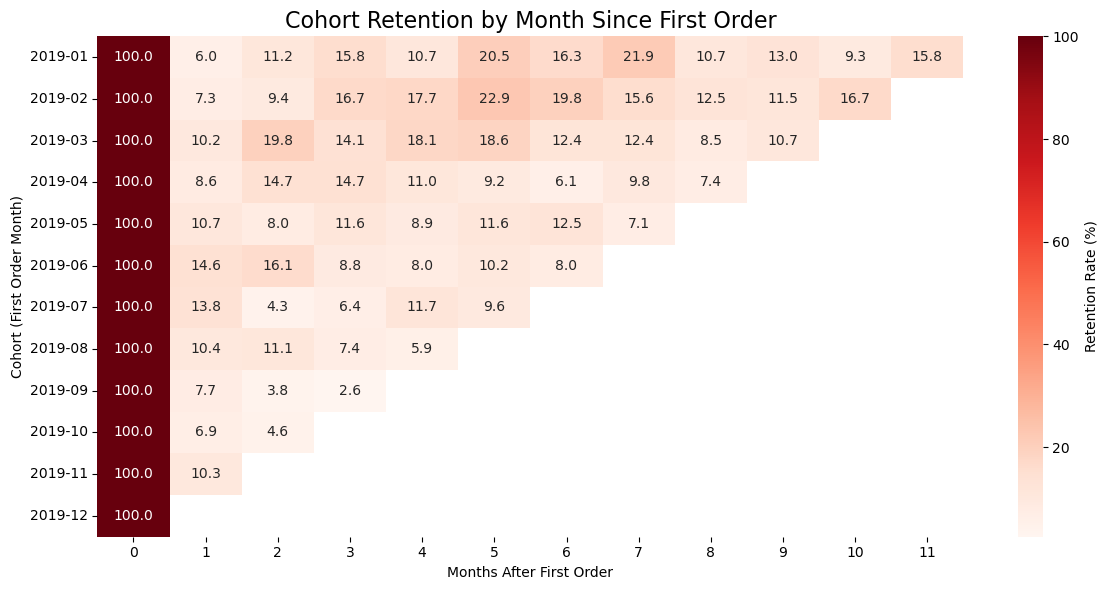

In [50]:

plt.figure(figsize=(12, 6))
sns.heatmap(
    cohorts_pivot ,
    annot = True ,             
    fmt = ".1f",                
    cmap = "Reds" ,             
    cbar_kws = {'label': 'Retention Rate (%)'}
)

plt.title("Cohort Retention by Month Since First Order", fontsize=16)
plt.xlabel("Months After First Order")
plt.ylabel("Cohort (First Order Month)")
plt.tight_layout()
plt.show()


### Plotting the average retention curve:

<Axes: title={'center': 'Average Retention Curve'}, xlabel='Months After First Order', ylabel='Retention Rate (%)'>

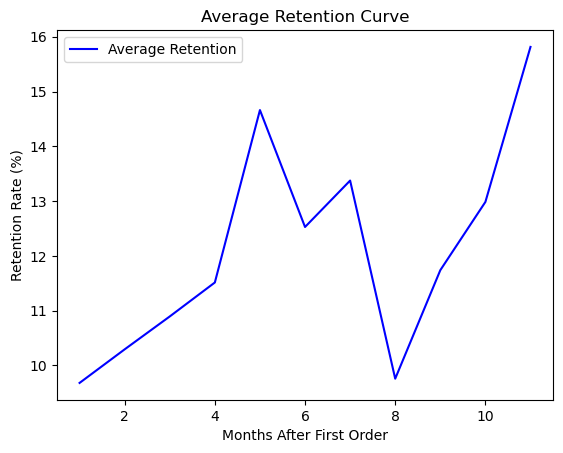

In [51]:
cohorts_avg = cohorts.groupby('months_post_first' , as_index = False).agg(
    avg_retention_rate = ('retention_rate' , 'mean'))

cohorts_avg[cohorts_avg['months_post_first'] > 0].plot(
    kind ='line' , 
    x = 'months_post_first' , 
    y = 'avg_retention_rate' , 
    color = 'blue' ,  
    title = "Average Retention Curve" , 
    xlabel = "Months After First Order" , 
    ylabel = "Retention Rate (%)" , 
    label = "Average Retention")

### Note that the average retention rate for later months is computed out of a smaller and smaller number of observations, since the data has  a total of 12 months only.

### Creating a retention table, considering location (grouping by 'location' as well):

In [52]:
activity_location = sales.groupby(['location' , 'cohort_month' , 'months_post_first'] , as_index = False).agg(
    active_users = ('customer_id' , 'nunique'))
cohorts_location = sales.groupby(['location' , 'cohort_month'] , as_index = False).agg(
    total_users = ('customer_id' , 'nunique'))

cohorts_location = cohorts_location.merge(activity_location , on = ['location' , 'cohort_month'] , how = 'left')

cohorts_location['retention_rate'] = 100*cohorts_location['active_users'].fillna(0)/cohorts_location['total_users']


### Creating a heatmap for each location seperately:

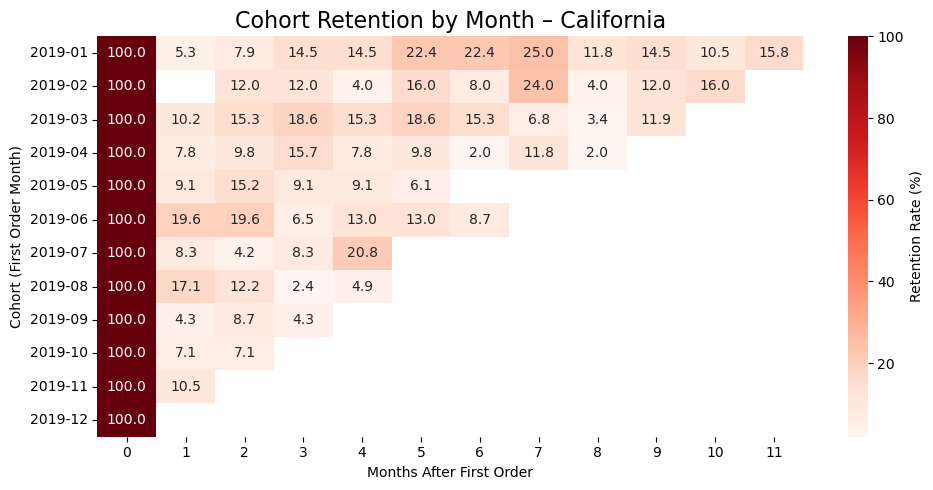

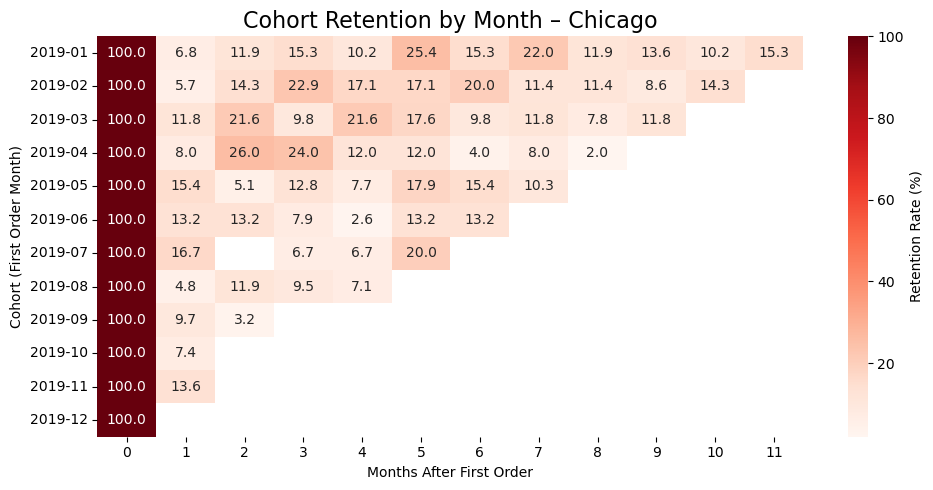

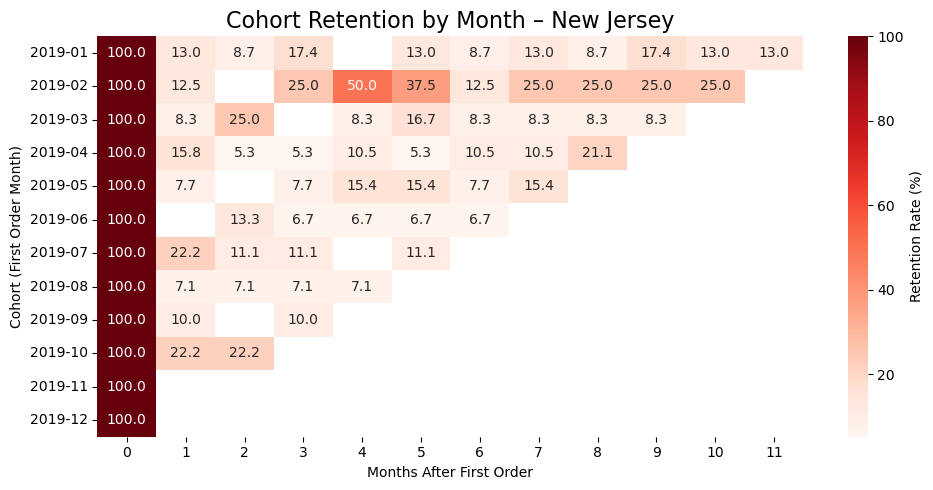

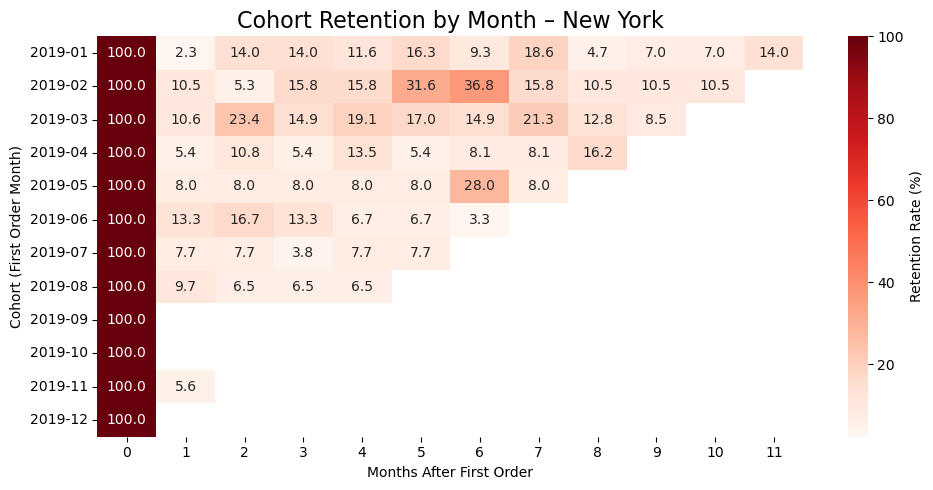

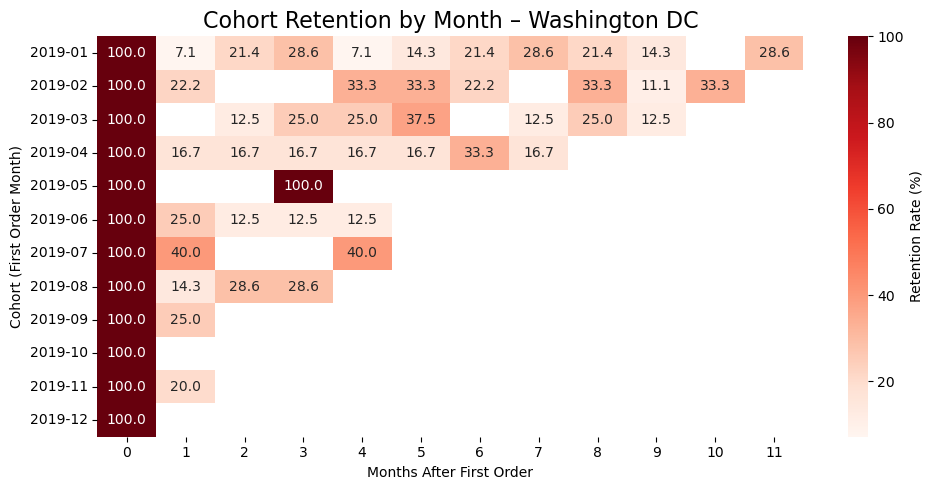

In [53]:
for loc in cohorts_location['location'].unique():
    pivot = cohorts_location[cohorts_location['location'] == loc].pivot(
        index='cohort_month',
        columns='months_post_first',
        values='retention_rate'
    )
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="Reds",
        cbar_kws={'label': 'Retention Rate (%)'}
    )
    plt.title(f"Cohort Retention by Month – {loc}", fontsize=16)
    plt.xlabel("Months After First Order")
    plt.ylabel("Cohort (First Order Month)")
    plt.tight_layout()
    plt.show()

### Adding a retention table with absolute numbers for each location:

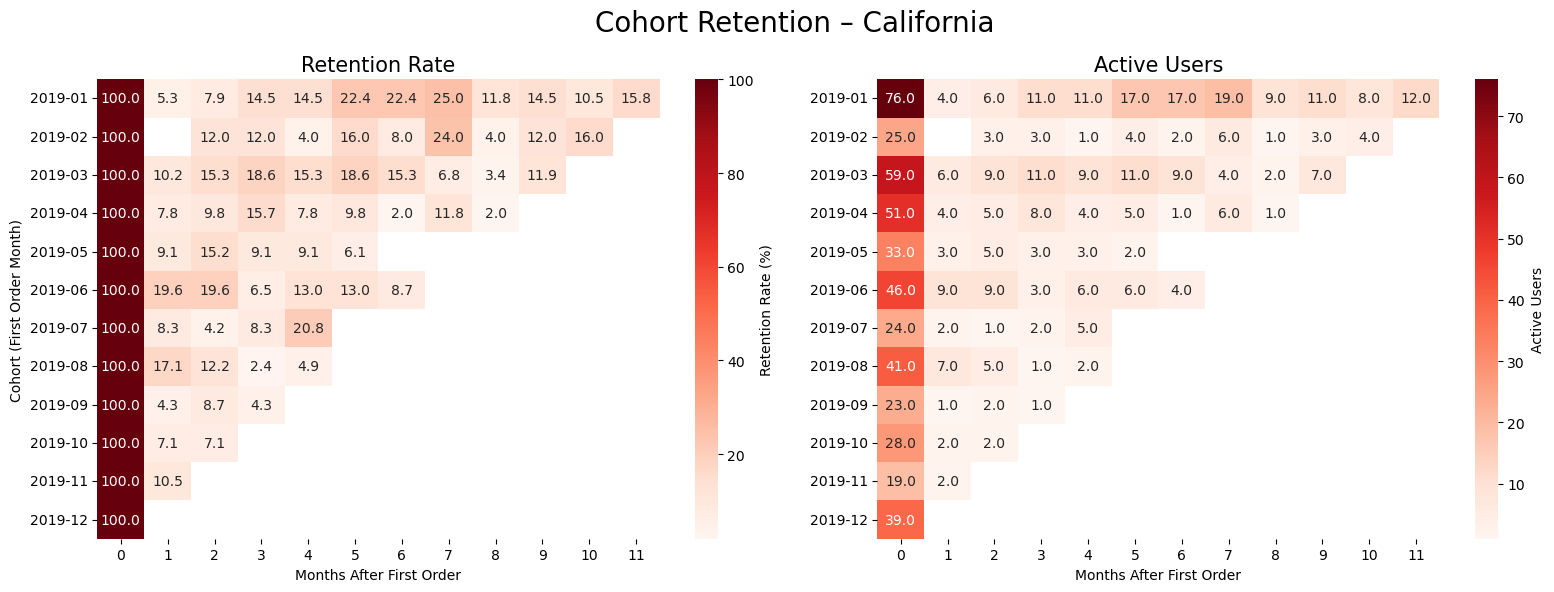

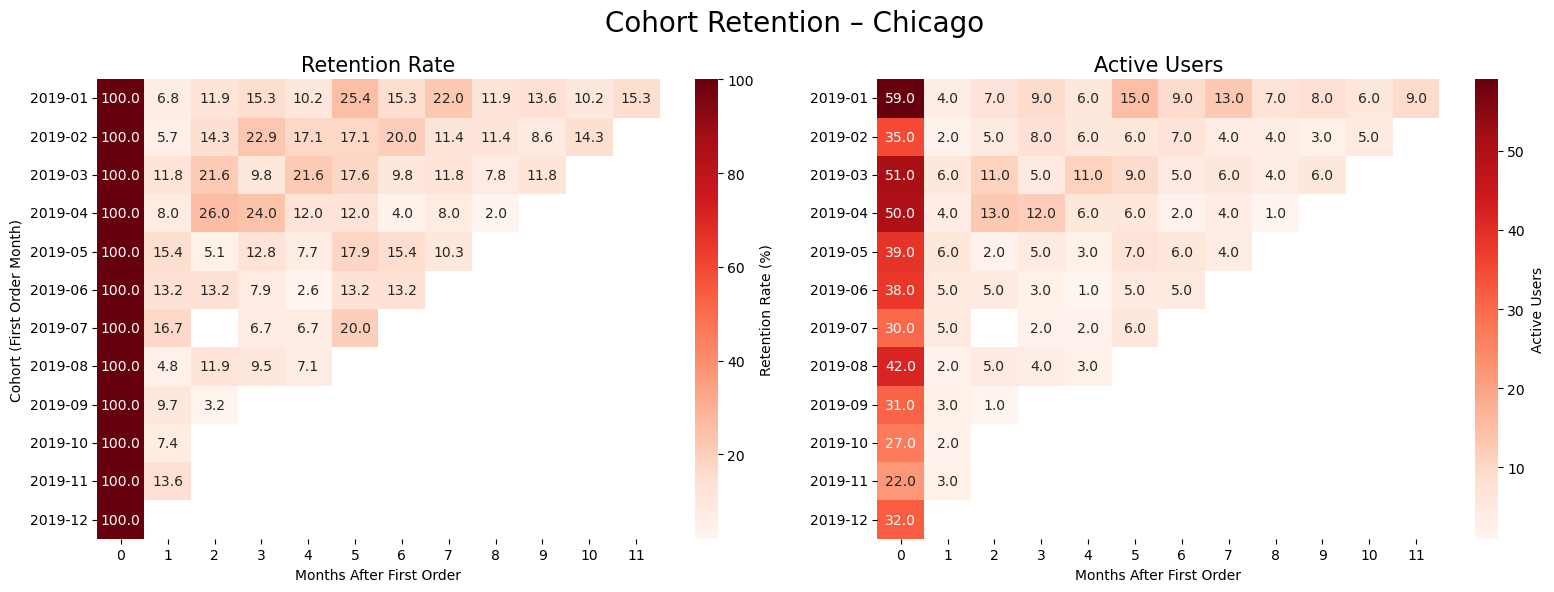

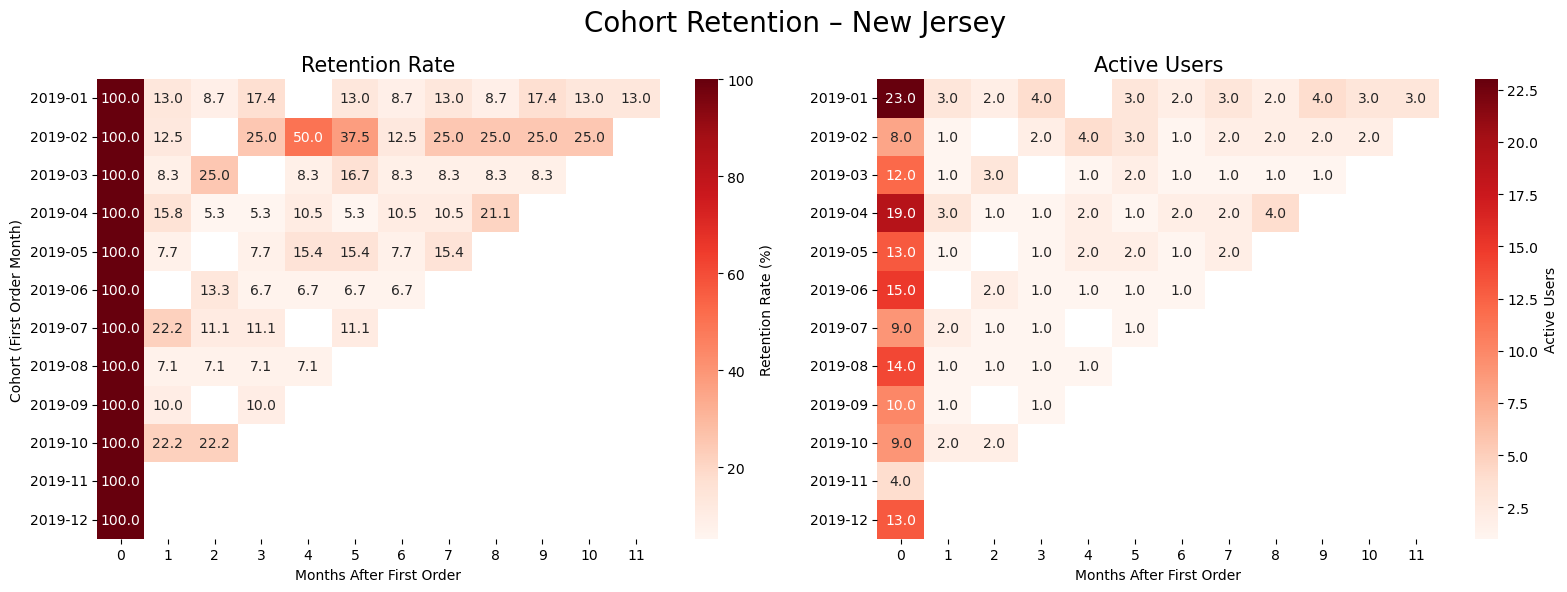

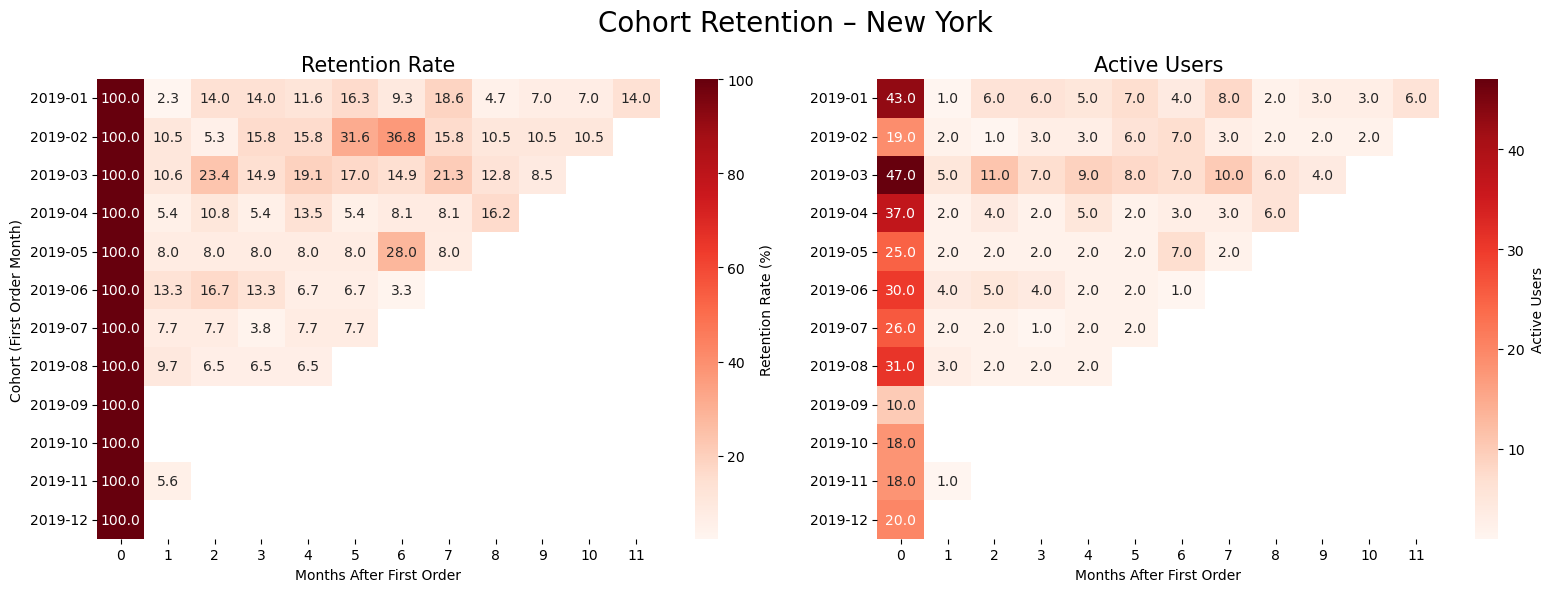

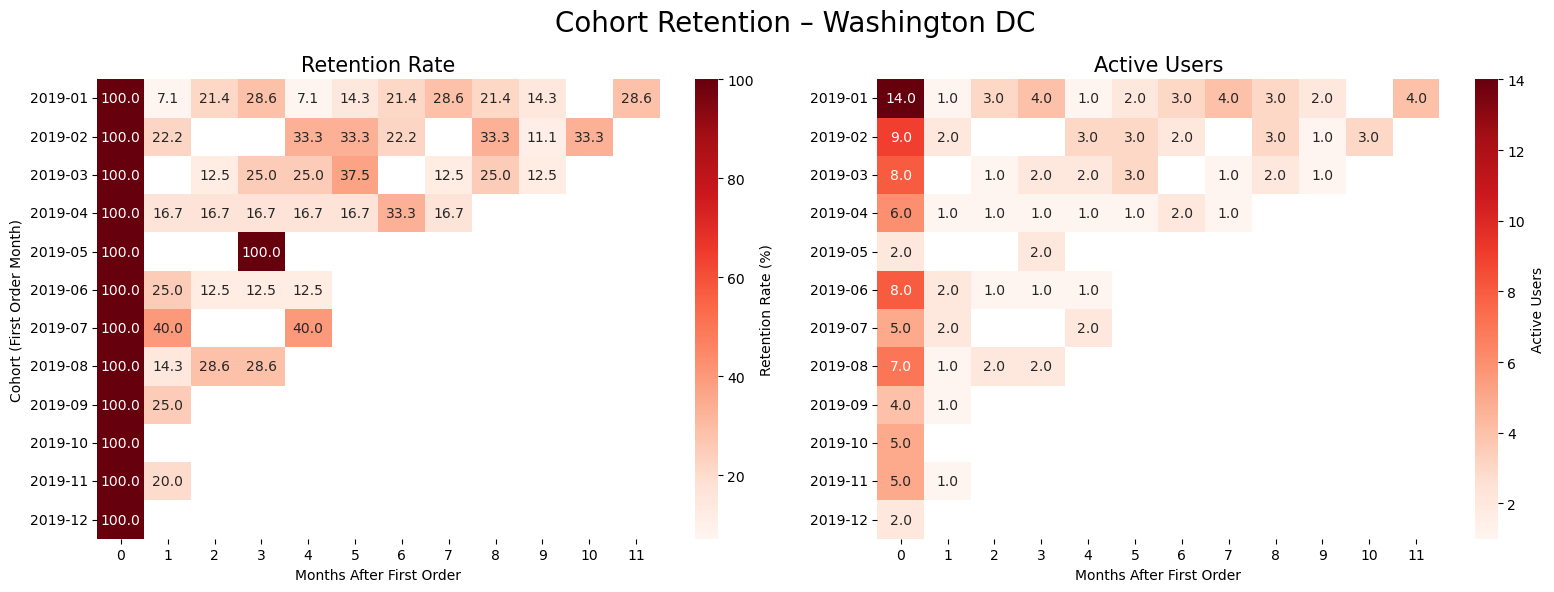

In [54]:


for loc in cohorts_location['location'].unique():
    pivot_retention = cohorts_location[cohorts_location['location'] == loc].pivot(
        index = 'cohort_month' ,
        columns = 'months_post_first' ,
        values = 'retention_rate'
    )
    pivot_active = cohorts_location[cohorts_location['location'] == loc].pivot(
        index = 'cohort_month' ,
        columns = 'months_post_first' ,
        values = 'active_users'
    )

    fig, ax = plt.subplots(1 , 2 , figsize=(16 , 6))
    fig.suptitle(f"Cohort Retention – {loc}", fontsize = 20)

    sns.heatmap(
        pivot_retention ,
        annot = True ,
        fmt = ".1f" ,
        cmap = "Reds" ,
        cbar_kws = {'label': 'Retention Rate (%)'} ,
        ax = ax[0]
    )
    ax[0].set_title("Retention Rate" , fontsize = 15)
    ax[0].set_xlabel("Months After First Order")
    ax[0].set_ylabel("Cohort (First Order Month)")

    sns.heatmap(
        pivot_active,
        annot = True ,
        fmt = ".1f" ,
        cmap = "Reds" ,
        cbar_kws = {'label': 'Active Users'} ,
        ax = ax[1]
    )
    ax[1].set_title("Active Users" , fontsize = 15)
    ax[1].set_xlabel("Months After First Order")
    ax[1].set_ylabel("")

    plt.tight_layout()  
    plt.show()


### Plotting the average retention curve, by location:

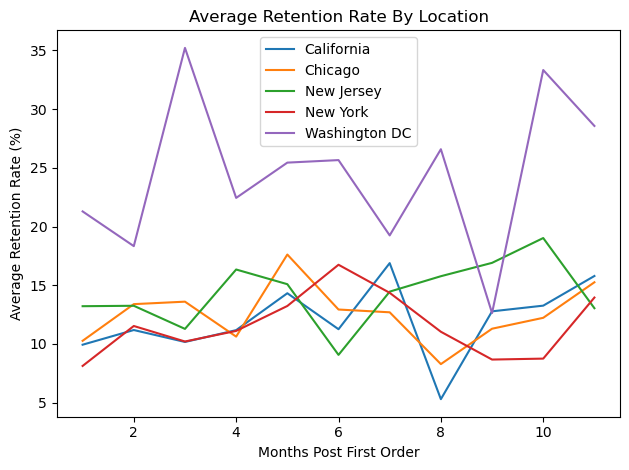

In [55]:
cohorts_mean = cohorts_location.groupby(['location' , 'months_post_first'] , as_index = False).agg(
    avg_retention = ('retention_rate' , 'mean'))


fig , ax = plt.subplots()

for loc in cohorts_mean['location'].unique():
    cohorts_mean[(cohorts_mean['location'] == loc) & (cohorts_mean['months_post_first'] > 0)].plot(
        x = 'months_post_first' , 
        y = 'avg_retention' ,
        kind = 'line' ,
        ax = ax ,
        label = loc)

ax.set_title("Average Retention Rate By Location")
ax.set_xlabel("Months Post First Order")
ax.set_ylabel("Average Retention Rate (%)")

plt.tight_layout()
plt.show()





### Plotting total monthly revenue, by location:

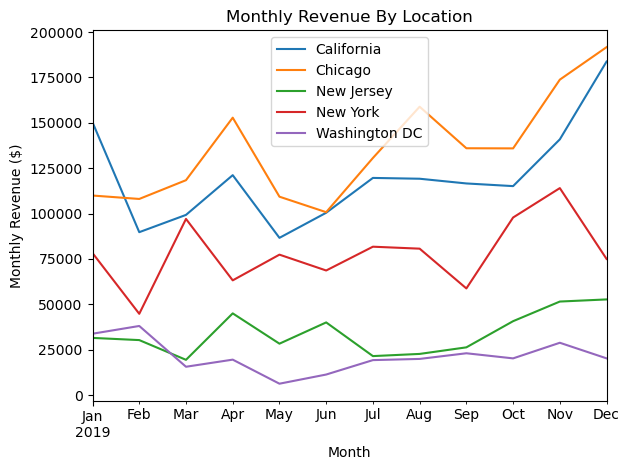

In [56]:
location_monthly = sales.groupby(['location' , 'month'] , as_index = False).agg(
    monthly_revenue = ('amount' , 'sum'))

fig , ax = plt.subplots()

for loc in location_monthly['location'].unique():
    location_monthly[location_monthly['location'] == loc].plot(
        x = 'month' , 
        y = 'monthly_revenue' , 
        kind = 'line' , 
        ax = ax ,
        label = loc)


ax.set_title("Monthly Revenue By Location")
ax.set_xlabel("Month")
ax.set_ylabel("Monthly Revenue ($)")
ax.legend()


plt.tight_layout()
plt.show()

### Getting the top-3 products by revenue for each location:

In [57]:
sales['product_sku'].nunique() ## 1145

location_products = sales.groupby(['location' , 'product_sku' , 'product_description'] , as_index = True).agg(
   total_revenue = ('amount' , 'sum'))

location_products['rank'] = location_products.groupby('location')['total_revenue'].rank(
    method = 'dense' , ascending = False)


location_products[location_products['rank'] <= 3].sort_values(
    by = ['location' , 'rank'] , ascending = (True, True))


total_revenue  \
location      product_sku    product_description                                                 
California    GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...      212750.84   
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA                  188180.71   
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                   157122.22   
Chicago       GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...      240507.59   
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA                  211180.12   
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                   174034.08   
New Jersey    GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...       57960.71   
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA                   51969.83   
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                    50674.39   
New York      GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...      143357.75   
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA                  139274.45   
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                   115758.77   
Washington DC GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA                   39372.01   
              GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...       34339.45   
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                    31023.47   

                                                                                 rank  
location      product_sku    product_description                                       
California    GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...   1.0  
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA               2.0  
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                3.0  
Chicago       GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...   1.0  
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA               2.0  
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                3.0  
New Jersey    GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...   1.0  
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA               2.0  
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                3.0  
New York      GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...   1.0  
              GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA               2.0  
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                3.0  
Washington DC GGOENEBQ078999 Nest Cam Outdoor Security Camera - USA               1.0  
              GGOENEBJ079499 Nest Learning Thermostat 3rd Gen-USA - Stainles...   2.0  
              GGOENEBB078899 Nest Cam Indoor Security Camera - USA                3.0

## Final conclusions:
- Chicago, California, and New York generate the highest total revenue across all locations.
  
- While these locations have larger customer bases, average retention rates are similar across most regions, with the exception of Washington DC, which shows slightly higher retention and fewer customers overall.

  
- The dataset spans 12 months, thus limiting insight into longer-term retention patterns. However, a moderate increase in retention is visible around the sixth month after the first order.

  
- The Nest Learning Thermostat 3rd Gen – USA (Stainless Steel) is the top-revenue product in four of the five locations, with Washington DC being the only exception.


## Recommendations

- Maintain marketing focus in high-revenue locations (Chicago, California, and New York) while exploring strategies to improve customer acquisition in lower-volume areas such as Washington DC.
  
- Investigate the mid-year retention increase to determine whether it reflects seasonality or other factors that could be leveraged in future campaigns.

  
- Consider targeted promotion or bundling of the Nest Learning Thermostat 3rd Gen in underperforming regions, given its consistent performance elsewhere.

  
- Extend retention tracking beyond the 12-month period to assess long-term customer engagement and identify stable retention trends.